In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from XVA import *
from XVAFBSNNs import *

In [3]:
from FBSNNs import *
from ForwardContracts import *

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64 # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 25 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 2 * [45] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = ForwardContracts(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [5]:
model.load_model("models/Forward25D.pth")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 25 # number of dimensions
Mm = N ** (1/5)

layers = [D+1] + 2 * [256] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
xvamodel = XVA(Xi, T, M, N, D, Mm, layers, mode, activation, model)

n_iter = 1 * 10**3
lr = 1e-3

In [7]:
n_iter = 6 * 10**2
lr = 1e-6

In [10]:
tot = time.time()
print(xvamodel.device)
graph = xvamodel.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 3400, Loss: 3.798e-03, Y0: 0.010, Time: 0.59, Learning Rate: 1.000e-06
It: 3500, Loss: 3.709e-03, Y0: 0.010, Time: 24.53, Learning Rate: 1.000e-06
It: 3600, Loss: 4.415e-03, Y0: 0.010, Time: 25.06, Learning Rate: 1.000e-06
It: 3700, Loss: 3.769e-03, Y0: 0.010, Time: 32.31, Learning Rate: 1.000e-06
It: 3800, Loss: 3.980e-03, Y0: 0.010, Time: 19.14, Learning Rate: 1.000e-06
It: 3900, Loss: 3.963e-03, Y0: 0.010, Time: 17.17, Learning Rate: 1.000e-06
total time: 135.7455174922943 s


In [7]:
xvamodel.load_model("models/25DForwardFVAXVAPaper.pth")

In [8]:
t_test, W_test, X_test, C_test = xvamodel.fetch_minibatch()
X_pred, Y_pred = xvamodel.predict(C_test, t_test, W_test, X_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(63):
    t_test_i, W_test_i, X_test_i, C_test_i = xvamodel.fetch_minibatch()
    X_pred_i, Y_pred_i = xvamodel.predict(C_test_i, t_test_i, W_test_i, X_test_i)
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)

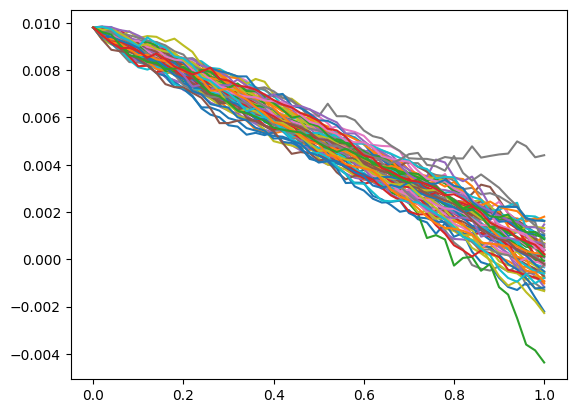

In [9]:
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')
plt.plot(t_test[1:64, :, 0].T, Y_pred[1:64, :, 0].T)
plt.show()

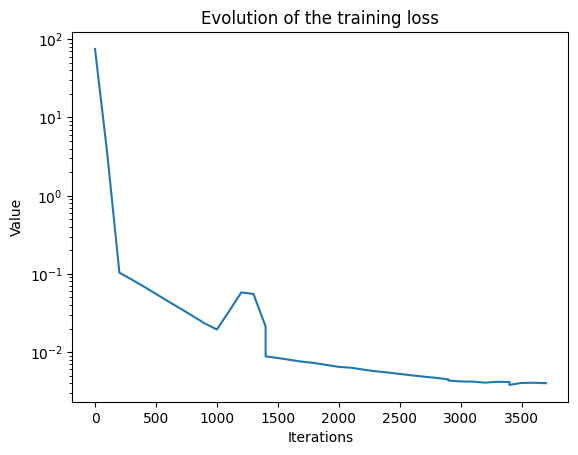

In [12]:
graph = xvamodel.iteration, xvamodel.training_loss
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
plt.show()

In [13]:
Y_pred.shape

(4096, 51, 1)

In [14]:
Y_preds = Y_pred.reshape(4096, 51)

In [15]:
pred_fva = Y_preds[:,0][0] * 100

In [16]:
pred_fva

0.9804985485970974

In [17]:
time_stamp = t_test[0].reshape(51,)
time_stamp

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32)

In [18]:
x_init = 250
strike = 250
r = 0.02
sigma = 0.25
total_time = 1
r_f = 0.04

In [19]:
exactYhat = x_init - strike*np.exp(-r * total_time)
exactY = np.exp(-(r_f - r) * total_time)*x_init - strike*np.exp(-r_f * total_time)
exact_fva = 10 * (exactYhat - exactY)

In [20]:
exact_fva

0.9802313470316903

In [21]:
(pred_fva - exact_fva) ** 2 / exact_fva ** 2

7.430547635392639e-08

In [22]:
np.abs(pred_fva - exact_fva) / exact_fva * 100

0.027259030862069617

In [23]:
np.abs(pred_fva - exact_fva) 

0.0002672015654070492

In [24]:
xvamodel.save_model("models/25DForwardFVAXVAPaper.pth")